In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

In [3]:
import pandas as pd
import numpy as np

# Read the dataset (again if needed)
merged_data = pd.read_parquet('../datasets/final_merged_dataset_hourly.parquet')

# Drop NaN rows (important because volatility, moving avg have NaNs at the start)
merged_data = merged_data.dropna()

# Define the features you want to use
feature_cols = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'sentiment_score', 'bert_sentiment',
    'prev_close', 'prev_vader_sentiment', 'prev_bert_sentiment',
    'volatility_7d', 'volatility_14d', 'volatility_30d',
    'closing_7d_avg', 'closing_30d_avg'
]

# Create input (X) and output (y)
data_X = merged_data[feature_cols].values
data_y = merged_data['Close'].values  # Target is Close price

# Define sequence length
N_STEPS = 24  # Use past 24 hours to predict next hour

# Create sequences
X_seq = []
y_seq = []

for i in range(N_STEPS, len(data_X)):
    X_seq.append(data_X[i-N_STEPS:i])
    y_seq.append(data_y[i])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

print(f"X_seq shape: {X_seq.shape}")  # (samples, 24, features)
print(f"y_seq shape: {y_seq.shape}")  # (samples,)


X_seq shape: (18241, 24, 15)
y_seq shape: (18241,)


In [4]:
X_seq

array([[[0.25073012, 0.25110647, 0.25062839, ..., 0.05731247,
         0.32097504, 0.35758326],
        [0.25143256, 0.25169481, 0.25135292, ..., 0.05731247,
         0.32097504, 0.35758326],
        [0.25615368, 0.25601089, 0.25526346, ..., 0.05731247,
         0.32097504, 0.35758326],
        ...,
        [0.2573224 , 0.25800473, 0.2572696 , ..., 0.05731247,
         0.32097504, 0.35758326],
        [0.25937201, 0.25922932, 0.25901467, ..., 0.05731247,
         0.32097504, 0.35758326],
        [0.25544369, 0.25530088, 0.25361524, ..., 0.05731247,
         0.32097504, 0.35758326]],

       [[0.25143256, 0.25169481, 0.25135292, ..., 0.05731247,
         0.32097504, 0.35758326],
        [0.25615368, 0.25601089, 0.25526346, ..., 0.05731247,
         0.32097504, 0.35758326],
        [0.25214727, 0.25292752, 0.2523508 , ..., 0.05731247,
         0.32097504, 0.35758326],
        ...,
        [0.25937201, 0.25922932, 0.25901467, ..., 0.05731247,
         0.32097504, 0.35758326],
        [0.2

In [5]:
# How much percentage for training
train_size = int(0.8 * len(X_seq))

# Split chronologically
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

print(f"Train X shape: {X_train.shape}")
print(f"Test X shape: {X_test.shape}")
print(f"Train y shape: {y_train.shape}")
print(f"Test y shape: {y_test.shape}")


Train X shape: (14592, 24, 15)
Test X shape: (3649, 24, 15)
Train y shape: (14592,)
Test y shape: (3649,)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define LSTM model
lstm_model = Sequential()

# LSTM layer
lstm_model.add(LSTM(units=64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))

# Dropout layer (to prevent overfitting)
lstm_model.add(Dropout(0.2))

# Final Dense layer
lstm_model.add(Dense(1))  # 1 output: next-hour Close price

# Compile the model
lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Summary
lstm_model.summary()


/opt/anaconda3/envs/bit_pred_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,545 (80.25 KB)

 Trainable params: 20,545 (80.25 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

# Train the model
history = lstm_model.fit(
    X_train, 
    y_train,
    epochs=50,                 # maximum 50 epochs
    batch_size=32,
    validation_split=0.2,      # 20% of training set used for validation
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/50
365/365 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0198 - mae: 0.0896 - val_loss: 4.4844e-04 - val_mae: 0.0199
Epoch 2/50
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0020 - mae: 0.0350 - val_loss: 1.4563e-04 - val_mae: 0.0101
Epoch 3/50
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0017 - mae: 0.0310 - val_loss: 9.3807e-05 - val_mae: 0.0081
Epoch 4/50
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0015 - mae: 0.0296 - val_loss: 1.6890e-04 - val_mae: 0.0109
Epoch 5/50
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013 - mae: 0.0276 - val_loss: 2.7453e-04 - val_mae: 0.0151
Epoch 6/50
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0012 - mae: 0.0260 - val_loss: 1.4387e-04 - val_mae: 0.0104
Epoch 7/50
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.5077e-04 - mae: 0.0234 - val_loss: 2.7414e-04 - val_mae: 0.0146
Epoch 8/50
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9.5013e-04 - mae: 0.0232 - val_loss: 1.9769e-04 - val_mae: 0.0126


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Step 5.1: Predict on the test set
y_pred = lstm_model.predict(X_test)

# Step 5.2: Reshape predictions
y_pred = y_pred.flatten()

# Step 5.3: Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Step 5.4: Calculate Safe MAPE
threshold = 0.01  # ignore very small true values
mask = np.abs(y_test) > threshold
mape = mean_absolute_percentage_error(y_test[mask], y_pred[mask]) * 100

# Step 5.5: Display Results
print(f"✅ RMSE: {rmse:.6f}")
print(f"✅ Safe MAPE: {mape:.2f}%")


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ RMSE: 0.013126
✅ Safe MAPE: 37.64%


In [9]:
import sys
sys.path.append("../src")

from metric_logging import log_experiment

In [10]:
params = {
    "model_type": "LSTM",
    "sequence_length": 24,
    "hidden_units": 64,
    "dropout_rate": 0.2,
    "optimizer": "adam",
    "loss": "mean_squared_error",
    "epochs": 20,
    "batch_size": 32
}

# Define metrics
metrics = {
    "RMSE": rmse,
    "MAPE": mape
}

# Log model, parameters, and metrics
# log_experiment(
#     model_name="LSTM",
#     model_object=lstm_model,
#     params=params,
#     metrics=metrics
# )

In [11]:
lstm_model

<Sequential name=sequential, built=True>

In [14]:
import numpy as np

# -------------------------------------------------
# 1)  Copy X_test (shape: [samples, 24, features])
# -------------------------------------------------
X_test_noisy = X_test.copy()

# -------------------------------------------------
# 2)  Decide noise level  (e.g. 2 % of each feature’s range)
# -------------------------------------------------
noise_pct = 0.02         # 2 %
feature_range = X_test_noisy.max(axis=(0, 1)) - X_test_noisy.min(axis=(0, 1))
noise_std   = noise_pct * feature_range            # per‑feature σ

# -------------------------------------------------
# 3)  Add Gaussian noise feature‑wise
# -------------------------------------------------
noise = np.random.normal(loc=0.0,
                         scale=noise_std,
                         size=X_test_noisy.shape)

X_test_noisy += noise

# (optional)  clip to original min / max to avoid crazy outliers
X_test_noisy = np.clip(
    X_test_noisy,
    X_test.min(axis=(0, 1)),
    X_test.max(axis=(0, 1))
)

print("✅ Noisy test‑set created:", X_test_noisy.shape)

✅ Noisy test‑set created: (3649, 24, 15)


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# ------------------------------------------------------------------
# A)  Predict on the original (clean) test‑set
# ------------------------------------------------------------------
y_pred_clean = lstm_model.predict(X_test, verbose=0).flatten()

rmse_clean = np.sqrt(mean_squared_error(y_test, y_pred_clean))

threshold   = 0.01                       # ignore tiny targets
mask        = np.abs(y_test) > threshold
mape_clean  = mean_absolute_percentage_error(
                 y_test[mask], y_pred_clean[mask]) * 100

# ------------------------------------------------------------------
# B)  Predict on the NOISY test‑set we just built
# ------------------------------------------------------------------
y_pred_noisy = lstm_model.predict(X_test_noisy, verbose=0).flatten()

rmse_noisy = np.sqrt(mean_squared_error(y_test, y_pred_noisy))

mape_noisy = mean_absolute_percentage_error(
                 y_test[mask], y_pred_noisy[mask]) * 100      # same mask

# ------------------------------------------------------------------
# C)  Report robustness (error increase)
# ------------------------------------------------------------------
def pct_increase(a, b):
    return (b - a) / a * 100

print("🔎  LSTM  —  OOD Noise Robustness\n"
      "--------------------------------")
print(f"Clean  RMSE : {rmse_clean:.6f}")
print(f"Noisy  RMSE : {rmse_noisy:.6f}  "
      f"({pct_increase(rmse_clean, rmse_noisy):+.1f} %)\n")

print(f"Clean  Safe MAPE : {mape_clean:.2f}%")
print(f"Noisy  Safe MAPE : {mape_noisy:.2f}%  "
      f"({pct_increase(mape_clean, mape_noisy):+.1f} %)")

🔎  LSTM  —  OOD Noise Robustness
--------------------------------
Clean  RMSE : 0.013126
Noisy  RMSE : 0.013265  (+1.1 %)

Clean  Safe MAPE : 37.64%
Noisy  Safe MAPE : 37.99%  (+0.9 %)


<Figure size 700x500 with 0 Axes>

<Axes: xlabel='TrueClose', ylabel='AbsError'>

Text(0.5, 1.0, 'Heteroscedasticity Check\xa0–\xa0LSTM\nAbsolute Error vs. True Close Price')

Text(0.5, 0, 'True Close Price')

Text(0, 0.5, 'Absolute Prediction Error')

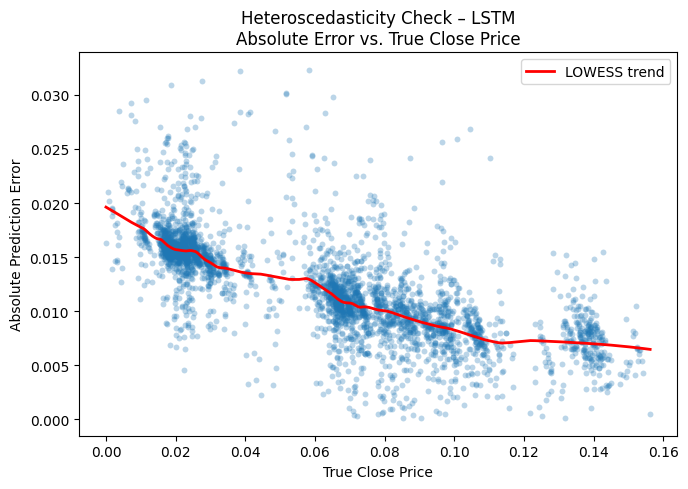

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess

# ------------------------------------------------------------------
# 1)  Make sure you have clean predictions (y_pred_clean)
#     If not, re‑compute quickly:
# y_pred_clean = lstm_model.predict(X_test, verbose=0).flatten()
# ------------------------------------------------------------------

errors = y_test - y_pred_clean
abs_errors = np.abs(errors)

# DataFrame for convenience
df_plot = pd.DataFrame({
    "TrueClose": y_test,
    "AbsError" : abs_errors
})

# ------------------------------------------------------------------
# 2)  LOWESS curve (optional smooth trend)
# ------------------------------------------------------------------
lowess_curve = lowess(df_plot["AbsError"], df_plot["TrueClose"],
                      frac=0.15, return_sorted=True)

# ------------------------------------------------------------------
# 3)  Plot
# ------------------------------------------------------------------
plt.figure(figsize=(7,5))
sns.scatterplot(data=df_plot, x="TrueClose", y="AbsError",
                alpha=0.3, s=18, linewidth=0)

# LOWESS
plt.plot(lowess_curve[:,0], lowess_curve[:,1],
         color="red", linewidth=2, label="LOWESS trend")

plt.title("Heteroscedasticity Check – LSTM\nAbsolute Error vs. True Close Price")
plt.xlabel("True Close Price")
plt.ylabel("Absolute Prediction Error")
plt.legend()
plt.tight_layout()
plt.show()

/opt/anaconda3/envs/bit_pred_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


  5%  | RMSE = 0.09742 | Safe MAPE = 176.02%


/opt/anaconda3/envs/bit_pred_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 10%  | RMSE = 0.02411 | Safe MAPE =  67.68%


/opt/anaconda3/envs/bit_pred_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 20%  | RMSE = 0.02715 | Safe MAPE =  68.20%


/opt/anaconda3/envs/bit_pred_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 40%  | RMSE = 0.00923 | Safe MAPE =  22.89%


/opt/anaconda3/envs/bit_pred_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 60%  | RMSE = 0.01498 | Safe MAPE =  41.37%


/opt/anaconda3/envs/bit_pred_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 80%  | RMSE = 0.01167 | Safe MAPE =  31.79%


/opt/anaconda3/envs/bit_pred_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


100%  | RMSE = 0.03107 | Safe MAPE =  90.36%


<Figure size 700x400 with 0 Axes>

Text(0.5, 0, 'Training‑set size (%)')

Text(0, 0.5, 'Error')

Text(0.5, 1.0, 'Double‑Descent Check\xa0– Plain\xa0LSTM')

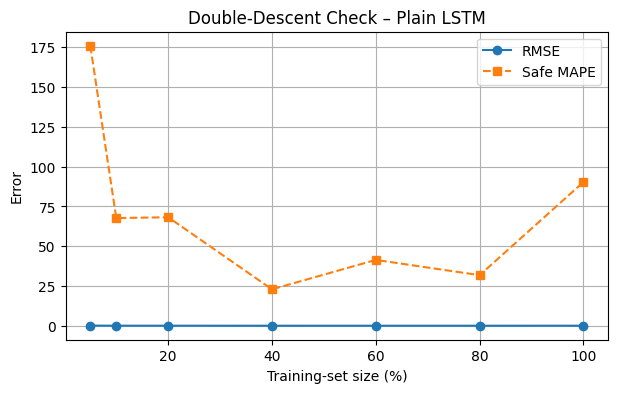

In [18]:
# ===============================================
# Double‑Descent experiment for *plain* LSTM
#  (re‑run this cell to regenerate the figure)
# ===============================================
import numpy as np, tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# -- 1.  Fractions of the *training* set to try
fractions = [0.05, 0.10, 0.20, 0.40, 0.60, 0.80, 1.00]

rmse_curve, mape_curve = [], []

for frac in fractions:
    # --- 1‑a.  Chronological subsample  ---------------------------
    n = int(frac * len(X_train))
    X_sub, y_sub = X_train[:n], y_train[:n]
    
    # --- 1‑b.  Fresh LSTM each pass  ------------------------------
    tf.keras.backend.clear_session()
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, input_shape=(X_sub.shape[1], X_sub.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    
    model.fit(
        X_sub, y_sub,
        epochs=20, batch_size=32,
        validation_split=0.2, verbose=0
    )
    
    # --- 1‑c.  Evaluate on the *fixed* test set -------------------
    y_pred = model.predict(X_test, verbose=0).flatten()
    
    rmse  = np.sqrt(mean_squared_error(y_test, y_pred))
    mask  = np.abs(y_test) > 0.01          # Safe‑MAPE mask
    mape  = mean_absolute_percentage_error(y_test[mask], y_pred[mask]) * 100
    
    rmse_curve.append(rmse)
    mape_curve.append(mape)
    
    print(f"{int(frac*100):>3}%  | RMSE = {rmse:.5f} | Safe MAPE = {mape:6.2f}%")

# -- 2.  Plot -------------------------------------------------------
plt.figure(figsize=(7,4))
plt.plot(np.array(fractions)*100, rmse_curve, 'o-',  label='RMSE')
plt.plot(np.array(fractions)*100, mape_curve, 's--', label='Safe MAPE')
plt.xlabel('Training‑set size (%)')
plt.ylabel('Error')
plt.title('Double‑Descent Check – Plain LSTM')
plt.grid(True); plt.legend(); plt.show()